# **E-Commerce Marketplace Analysis**
# Introduction

This notebook explores user behavior and revenue stagnation in a new online marketplace. The analysis focuses on user retention, product/market fit, and the identification of key growth metrics. Using cohort and behavioral data, we aim to develop actionable insights and propose data-driven hypotheses for testing.

### Steps:
1. **Cohort retention analysis** - to understand repeat purchase dynamics.  
2. **Product/market fit estimation** using repeat buyer share and retention  
3. **Key metric identification** - define 5 metrics tied to growth and profitability.  
4. **Hypothesis prioritization** - use the ICE framework to focus on high-impact ideas.  
5. **A/B test design** - propose measurable metrics to validate improvement hypotheses.

In [1]:
import pandas as pd
import numpy as np
from operator import attrgetter
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import requests


# 1. Data Overview

We will explore three key datasets: customers, orders, and order items.

In [3]:
!pip install opendatasets

In [4]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aokozlova
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce


100%|██████████| 42.6M/42.6M [00:00<00:00, 1.29GB/s]

In [5]:
#c_path = "/content/drive/MyDrive/Karpov_DA_projects/olist_customers_dataset.csv"
#o_path = "/content/drive/MyDrive/Karpov_DA_projects/olist_orders_dataset.csv"
#i_path = "/content/drive/MyDrive/Karpov_DA_projects/olist_order_items_dataset.csv"

#c_path = "https://disk.yandex.ru/d/YYRsaU1Fy5RiSQ"
#o_path = "https://disk.yandex.ru/d/wHpsXAoAbjh47A"
#i_path = "https://disk.yandex.ru/d/0nhiZwlHU1Rumg"

c_path = "/content/brazilian-ecommerce/olist_customers_dataset.csv"
o_path = "/content/brazilian-ecommerce/olist_orders_dataset.csv"
i_path = "/content/brazilian-ecommerce/olist_order_items_dataset.csv"


## Customers

In [6]:
customers = pd.read_csv(c_path)
#customers = yandex_read_csv(c_path)
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


**`olist_customers_dataset.csv` - This dataset has information about the customer and its location.**
  

`customer_id` - key to the orders dataset. Each order has a unique customer_id

`customer_unique_id` - unique identifier of a customer

`customer_zip_code_prefix` - first five digits of customer zip code

`customer_city` - customer city name

`customer_state`- customer state name


<br>We will inspect data types, check for missing values, and examine key characteristics of the dataset.

In [7]:
customers.isna().sum()

,0
customer_id,0
customer_unique_id,0
customer_zip_code_prefix,0
customer_city,0
customer_state,0


In [8]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [9]:

print(f"customer_id: {customers['customer_id'].nunique()}")
print(f"customer_unique_id: {customers['customer_unique_id'].nunique()}")
print(f"total: {customers.shape[0]}")

customer_id: 99441
customer_unique_id: 96096
total: 99441


We have customer_id and customer_unique_id.
The number of unique IDs is smaller than the number of order-level customer IDs.
We will use the unique customer IDs for further analysis.

Let's explore the distribution of users across states and cities.

In [10]:
print("Unique states: ",customers['customer_state'].nunique())
print("Unique cities: ",customers['customer_city'].nunique())

print("\nTop-5  states by %  of total amount of customers:\n")
print((customers["customer_state"].value_counts(normalize=True)*100).head())
print("\nTop-5  cities by %  of total amount of customers:\n")
print((customers["customer_city"].value_counts(normalize=True)*100).head())

print("\nNumber of cities with fewer than 10 users: " ,
      (customers.groupby("customer_city")["customer_unique_id"].nunique()<10).sum())

Unique states:  27
Unique cities:  4119

Top-5  states by %  of total amount of customers:

customer_state
SP    41.980672
RJ    12.924247
MG    11.700405
RS     5.496727
PR     5.073360
Name: proportion, dtype: float64

Top-5  cities by %  of total amount of customers:

customer_city
sao paulo         15.627357
rio de janeiro     6.920687
belo horizonte     2.788588
brasilia           2.142979
curitiba           1.529550
Name: proportion, dtype: float64

Number of cities with fewer than 10 users:  3178


Most customers come from just a few regions. São Paulo alone makes up over 40% of all users, and the top five states cover about 75% of the total.
At the city level, São Paulo and Rio de Janeiro lead by a large margin.
More than 3,000 cities have fewer than 10 users, meaning the platform reaches many places but has very few customers in most of them.

## Orders

In [11]:
orders = pd.read_csv(o_path)
#orders = yandex_read_csv(o_path)
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


**olist_orders_dataset.csv**

`order_id` - unique identifier of the order.

`customer_id` - key to the customer dataset. Each order has a unique customer_id.

`order_status` - Reference to the order status (delivered, shipped, etc).

`order_purchase_timestamp` - Shows the purchase timestamp.

`order_approved_at` - Shows the payment approval timestamp.

`order_delivered_carrier_date` - Shows the order posting timestamp. When it was handled to the logistic partner.

`order_delivered_customer_date` - Shows the actual order delivery date to the customer.

`order_estimated_delivery_date` - Shows the estimated delivery date that was informed to customer at the purchase moment.

<br>We will inspect data types, check for missing values, and examine key characteristics of the dataset.

In [12]:
orders.isna().sum()

,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,160
order_delivered_carrier_date,1783
order_delivered_customer_date,2965
order_estimated_delivery_date,0


In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [14]:
#changing str to datetime
for col in orders.columns[3::]:
    orders[col] = pd.to_datetime(orders[col])
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [15]:
ot_min = orders["order_purchase_timestamp"].min()
ot_max = orders["order_purchase_timestamp"].max()
print(f"We have order data from {ot_min} to {ot_max}")

print("\nOrder satus distribution:\n")
print(orders["order_status"].value_counts(normalize= True).sort_values(ascending = False) * 100 )

We have order data from 2016-09-04 21:15:19 to 2018-10-17 17:30:18

Order satus distribution:

order_status
delivered      97.020344
shipped         1.113223
canceled        0.628513
unavailable     0.612423
invoiced        0.315765
processing      0.302692
created         0.005028
approved        0.002011
Name: proportion, dtype: float64


In [16]:
#example of an order
orders[orders["order_id"]=="00143d0f86d6fbd9f9b38ab440ac16f5"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
36265,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06


What statuses orders with missing values have?

In [17]:
print("Missing values order status: \n")
print("order_delivered_customer_date")
print(orders[orders['order_delivered_customer_date'].isna()].order_status.value_counts())
print("\norder_delivered_carrier_date")
print(orders[orders['order_delivered_carrier_date'].isna()].order_status.value_counts())
print("\norder_approved_at")
print(orders[orders['order_approved_at'].isna()].order_status.value_counts())

Missing values order status: 

order_delivered_customer_date
order_status
shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: count, dtype: int64

order_delivered_carrier_date
order_status
unavailable    609
canceled       550
invoiced       314
processing     301
created          5
approved         2
delivered        2
Name: count, dtype: int64

order_approved_at
order_status
canceled     141
delivered     14
created        5
Name: count, dtype: int64


Most missing delivery and carrier dates come from canceled or unavailable orders. That means these orders never reached the delivery stage, so the missing values are expected.
A few missing values also appear in statuses like shipped or invoiced, which could point to incomplete tracking or data not updated after shipment.
The small number of missing dates for delivered orders likely reflects logging or synchronization errors rather than real delivery issues.



We can see missing data for some delivered orders, it might be better to remove them from the analysis in the future.

Are there any inconsistencies in the data?
Let’s count the cases where event dates are not logically ordered

In [18]:

print("Number of orders where the approval date is earlier than the purchase date",
      orders[orders["order_approved_at"]<orders["order_purchase_timestamp"]].shape[0])
print("Number of orders where the delivered carier date is earlier than the purchase date",
      orders[orders["order_delivered_carrier_date"]<orders["order_purchase_timestamp"]].shape[0])
print("Number of orders where the delivery date is earlier than the purchase date",
      orders[orders["order_delivered_customer_date"]<orders["order_purchase_timestamp"]].shape[0])
print("Number of orders where the estimated delivery date is earlier than the purchase date",
      orders[orders["order_estimated_delivery_date"]<orders["order_purchase_timestamp"]].shape[0])
print("Number of orders where the delivered carier date is earlier than the approval date",
      orders[orders["order_delivered_carrier_date"]<orders["order_approved_at"]].shape[0])
print("Number of orders where the delivery date is earlier than then the delivery carier date",
      orders[orders["order_delivered_customer_date"]<orders["order_delivered_carrier_date"]].shape[0])
print("Number of orders where the estimated delivery date is earlier than  the delivered carrier date",
      orders[orders["order_estimated_delivery_date"]<orders["order_delivered_carrier_date"]].shape[0])

Number of orders where the approval date is earlier than the purchase date 0
Number of orders where the delivered carier date is earlier than the purchase date 166
Number of orders where the delivery date is earlier than the purchase date 0
Number of orders where the estimated delivery date is earlier than the purchase date 0
Number of orders where the delivered carier date is earlier than the approval date 1359
Number of orders where the delivery date is earlier than then the delivery carier date 23
Number of orders where the estimated delivery date is earlier than  the delivered carrier date 473


The dataset is mostly consistent, but a small share of orders have unrealistic date sequences related to carier, likely caused by system lags or incorrect logging.

How many orders were delayed?

In [19]:
print("Delayed orders:",
      round((orders["order_estimated_delivery_date"] < orders["order_delivered_customer_date"]).sum()*100/
      orders.loc[orders["order_status"] == "delivered","order_id"].nunique(),2),"%"
      )

#median delay period
_delayed_orders = orders[orders["order_estimated_delivery_date"] < orders["order_delivered_customer_date"]]
delay_days = (_delayed_orders["order_delivered_customer_date"] - _delayed_orders["order_estimated_delivery_date"]).median()
print(f"Median delay period is {delay_days.days} days")


Delayed orders: 8.11 %
Median delay period is 5 days


## Items

In [20]:
items = pd.read_csv(i_path)
#items = yandex_read_csv(i_path)
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


**olist_order_items_dataset.csv - This dataset includes data about the items purchased within each order**

`order_id` - order unique identifier

`order_item_id` - sequential number identifying number of items included in the same order.

`product_id` - product unique identifier

`seller_id` - seller unique identifier

`shipping_limit_date` - Shows the seller shipping limit date for handling the order over to the logistic partner.

`price` - item price

`freight_value` - item freight value item (if an order has more than one item the freight value is splitted between items)


<br>We will inspect data types, check for missing values, and examine key characteristics of the dataset.

In [21]:
items.isna().sum()

,0
order_id,0
order_item_id,0
product_id,0
seller_id,0
shipping_limit_date,0
price,0
freight_value,0


In [22]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [23]:
# changing str to datetime
items["shipping_limit_date"] = pd.to_datetime(items["shipping_limit_date"])

In [24]:
it_min = items["shipping_limit_date"].min()
it_max = items["shipping_limit_date"].max()
print(f"We have data from {it_min} until {it_max}")

We have data from 2016-09-19 00:15:34 until 2020-04-09 22:35:08


In [25]:
items[["price","freight_value"]].describe()

,price,freight_value
count,112650.000000,112650.000000
mean,120.653739,19.990320
std,183.633928,15.806405
min,0.850000,0.000000
25%,39.900000,13.080000
50%,74.990000,16.260000
75%,134.900000,21.150000
max,6735.000000,409.680000


We can see freight_value equals 0, let's check how many items have it

In [26]:
items[items["freight_value"] == 0].shape[0]

383

Typical order:

In [27]:

items[items["order_id"] == "00143d0f86d6fbd9f9b38ab440ac16f5"]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


In [28]:
items["order_item_id"].describe()

,order_item_id
count,112650.000000
mean,1.197834
std,0.705124
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,21.000000


## Data consistency check


In [29]:
o_c = orders["customer_id"].isin(customers["customer_id"].unique()).sum() - len(orders["customer_id"])
print("Number of customer_id values from the orders table that have no matching record in the customers table:", o_c )

c_o = customers["customer_id"].isin(orders["customer_id"].unique()).sum() - len(customers["customer_id"])
print("Number of customer_id values from the customers table that have no matching record in the orders table:", c_o )

i_o = items["order_id"].isin(orders["order_id"]).sum() - len(items["order_id"])
print("Number of order_id values from the items table that have no matching record in the orders table:", i_o )

o_i = orders["order_id"].isin(items["order_id"]).sum() - len(orders["order_id"])
print("Number of order_id values from the orders table that have no matching record in the items table:", o_i*(-1) )



Number of customer_id values from the orders table that have no matching record in the customers table: 0
Number of customer_id values from the customers table that have no matching record in the orders table: 0
Number of order_id values from the items table that have no matching record in the orders table: 0
Number of order_id values from the orders table that have no matching record in the items table: 775


# Data Processing Summary

* Data on customers, orders, and products were successfully loaded and processed.

* The customer dataset contains two ID fields. We will use `customer_unique_id`, since one person can have multiple `customer_id` values.

* In the orders data, some delivery date anomalies were found - deliveries recorded earlier than the expected order cycle. In particular, 1,359 orders show the carrier delivery date earlier than the approval date. This anomaly will be considered in further analysis.

* A few delivered orders are missing key timestamps: 14 without approval dates, 2 without carrier delivery dates, and 8 without customer delivery dates. This may indicate minor bugs in order tracking or data collection.

* 7,827 or 8.11% of orders were delayed, with a median delay of 5 days, suggesting moderate delivery performance issues.

* We’ll keep the records with missing values for further analysis, as they may help explain the underlying issues — such as system bugs or process errors that lead to order cancellations and delivery failures

# 2. Retention

Next, we’ll look at how many customers come back each month - this shows if people keep using the marketplace or leave after the first purchase. Retention is key for steady revenue growth and for finding signs of product–market fit.

<br>**Steps:**

 - Decide which orders to include in the retention calculation.

 - Build a monthly retention table showing how many customers from each signup month return later.

 - Find the median first-month retention - how many people usually come back in the month after their first purchase.

 - Find which cohort keeps the most customers by month 3 - to see when retention was strongest.

In [30]:
orders["order_status"].value_counts()

,count
order_status,
delivered,96478
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
created,5
approved,2


We will calculate retention based on delivered orders, since they represent the full purchase cycle and exclude canceled or incomplete transactions.
For the calculation, we’ll use unique customer IDs (customer_unique_id), as one person can have multiple order-level IDs.

Cohorts will be defined by the date of the purchase, and retention will reflect how many customers made additional delivered purchases in later months.


In [31]:
orders_customers = orders.merge(customers, on = "customer_id")
orders_delivered = orders_customers[orders_customers["order_status"] == "delivered"].copy()
orders_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [32]:
orders_delivered.shape

(96478, 12)

In [33]:
print("We have data from ", orders_delivered["order_purchase_timestamp"].min(), "until", orders_delivered["order_purchase_timestamp"].max())

We have data from  2016-09-15 12:16:38 until 2018-08-29 15:00:37


In [34]:
#extract day and month of purchase
orders_delivered["purchase_month"] = orders_delivered["order_purchase_timestamp"].dt.to_period("M")
orders_delivered["purchase_day"] = orders_delivered["order_purchase_timestamp"].dt.to_period("D")

#making cohorts
orders_delivered["cohort"] = orders_delivered.groupby("customer_unique_id")["order_purchase_timestamp"].transform("min").dt.to_period('M')
orders_delivered["cohort_day"] = orders_delivered.groupby("customer_unique_id")["order_purchase_timestamp"].transform("min").dt.to_period('D')

# calculate number of mothly periods
orders_delivered['period_number_month'] = (
                  np.floor((orders_delivered.purchase_day - orders_delivered.cohort_day).
                  apply(attrgetter('n')) / 30))
orders_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,purchase_month,purchase_day,cohort,cohort_day,period_number_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,2017-10-02,2017-09,2017-09-04,0.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07,2018-07-24,2018-07,2018-07-24,0.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08,2018-08-08,2018-08,2018-08-08,0.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11,2017-11-18,2017-11,2017-11-18,0.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02,2018-02-13,2018-02,2018-02-13,0.0


In [35]:
#create cohort table
cohort = (orders_delivered.groupby(["cohort","period_number_month"], as_index = False)
         ["customer_unique_id"].nunique()
         .rename({"customer_unique_id":"n_customers"},axis = 1)
         .pivot(columns = "period_number_month", index = "cohort", values = "n_customers")

)
cohort.head(10)

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,262.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,1.0,1.0
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,717.0,2.0,NaN,4.0,1.0,1.0,2.0,2.0,NaN,NaN,...,4.0,3.0,2.0,NaN,2.0,2.0,2.0,1.0,NaN,NaN
2017-02,1628.0,2.0,3.0,6.0,4.0,2.0,4.0,1.0,2.0,4.0,...,6.0,1.0,3.0,2.0,1.0,1.0,3.0,NaN,NaN,NaN
2017-03,2503.0,7.0,13.0,11.0,3.0,2.0,9.0,4.0,6.0,6.0,...,4.0,4.0,3.0,7.0,2.0,3.0,2.0,NaN,NaN,NaN
2017-04,2256.0,8.0,6.0,1.0,6.0,8.0,6.0,10.0,5.0,6.0,...,3.0,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN
2017-05,3451.0,14.0,14.0,8.0,13.0,11.0,11.0,4.0,10.0,9.0,...,11.0,6.0,3.0,7.0,4.0,NaN,NaN,NaN,NaN,NaN
2017-06,3037.0,13.0,15.0,11.0,5.0,16.0,9.0,6.0,4.0,10.0,...,9.0,3.0,9.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
#montly new customers - the cohorts size
cohort_size = cohort.iloc[:,0]
cohort_size.head()

,0.0
cohort,
2016-09,1.0
2016-10,262.0
2016-12,1.0
2017-01,717.0
2017-02,1628.0


In [37]:
#calculate retention
retention = cohort.divide(cohort_size,axis = 0)
retention.head()

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,...,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.003817,0.003817
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002789,NaN,0.005579,0.001395,0.001395,0.002789,0.002789,NaN,NaN,...,0.005579,0.004184,0.002789,NaN,0.002789,0.002789,0.002789,0.001395,NaN,NaN
2017-02,1.0,0.001229,0.001843,0.003686,0.002457,0.001229,0.002457,0.000614,0.001229,0.002457,...,0.003686,0.000614,0.001843,0.001229,0.000614,0.000614,0.001843,NaN,NaN,NaN


## Visualisation of retention

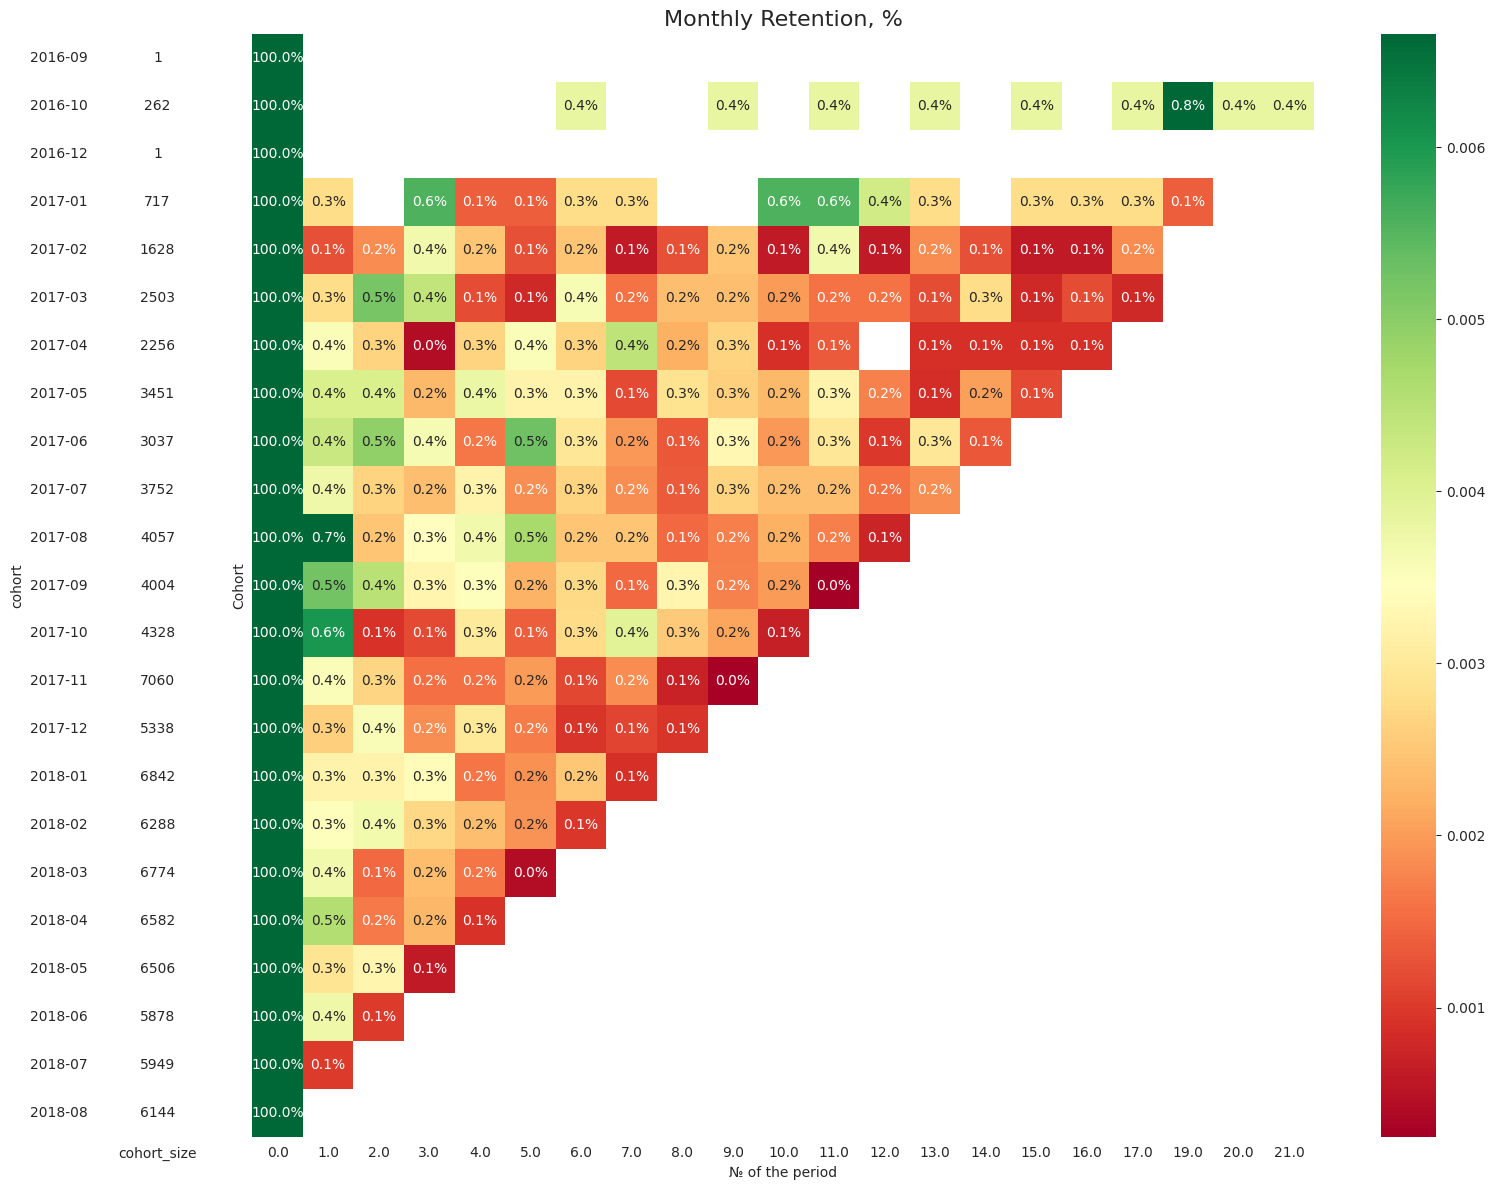

In [38]:

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})


    sns.heatmap(retention,
                mask=retention.isnull(),
                annot=True,
                fmt='.1%',
                cmap='RdYlGn',
                ax=ax[1],
                vmax = retention.iloc[:,1].max()
                )
    ax[1].set_title('Monthly Retention, %', fontsize=16)
    ax[1].set(xlabel='№ of the period', ylabel='Cohort')


    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

In [39]:
print(f"First month median retention: {round(retention.iloc[:,1].median()*100,2)}%")
print(f"Maximum retention after 3 months: {round(retention.iloc[:,3].max()*100,2)}% in {retention.iloc[:,3].idxmax()}")


First month median retention: 0.35%
Maximum retention after 3 months: 0.56% in 2017-01


The cohort heatmap shows a sharp decline in customer retention after the first month. Median retention after first month is 0.35%, and retention continues to fall over time.

This pattern suggests that most customers use the marketplace only once, with very limited long-term engagement. There’s no visible improvement in retention across newer cohorts, indicating that recent product or marketing changes haven’t yet increased repeat purchases.

Overall, the marketplace likely struggles to build user loyalty - customers convert but rarely return, which limits revenue growth despite ongoing user acquisition.

# 3. Product-Market Fit

Next, we’ll use cohort retention results to see whether the marketplace has reached product–market fit - if users find enough value to return.

Steps:

* Analyze the average retention rate for each month within a 12-month period.
* Calculate the repeat purchase rate for customers with delivered orders
* Analyze the number of new monthly customers to understand acquisition trends.

Let's visualizse average retention for the first 12 months after the purchase:

In [40]:
#remove first 3 cohorts
#take only cohorts with 12 months of activity
retention_1_year = retention.iloc[3:10,:13].transpose()
retention_1_year["avg_retention"] = retention_1_year.mean(axis = 1)
retention_1_year = retention_1_year.reset_index()

In [42]:
retention_1_year

cohort,period_number_month,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,avg_retention
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.0,0.002789,0.001229,0.002797,0.003546,0.004057,0.004281,0.003731,0.003204
2,2.0,NaN,0.001843,0.005194,0.002660,0.004057,0.004939,0.002665,0.003560
3,3.0,0.005579,0.003686,0.004395,0.000443,0.002318,0.003622,0.002399,0.003206
4,4.0,0.001395,0.002457,0.001199,0.002660,0.003767,0.001646,0.003198,0.002332
5,5.0,0.001395,0.001229,0.000799,0.003546,0.003187,0.005268,0.001866,0.002470
6,6.0,0.002789,0.002457,0.003596,0.002660,0.003187,0.002963,0.002665,0.002903
7,7.0,0.002789,0.000614,0.001598,0.004433,0.001159,0.001976,0.001866,0.002062
8,8.0,NaN,0.001229,0.002397,0.002216,0.002898,0.001317,0.001333,0.001898
9,9.0,NaN,0.002457,0.002397,0.002660,0.002608,0.003293,0.002665,0.002680


Text(0.5, 1.0, 'Avg Retention by month of activity')

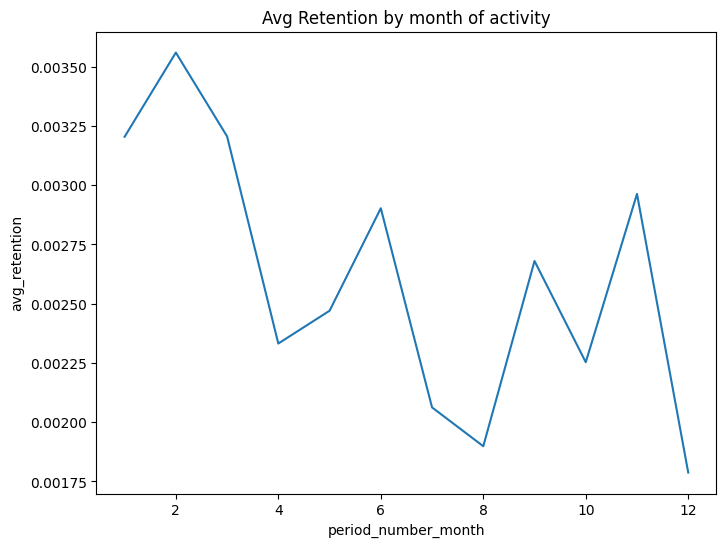

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(data = retention_1_year.iloc[1:,:], x = "period_number_month",y = "avg_retention", ax = ax)
plt.title("Avg Retention by month of activity")

At the same time, new customer acquisition is growing

Text(0.5, 1.0, 'New customers per month')

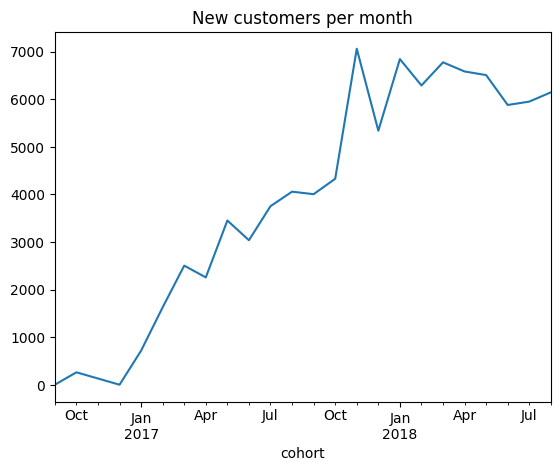

In [42]:
cohort_size.plot()
plt.title("New customers per month")

In [43]:
print(f'Median number of new customers per month: {cohort_size.median()}')

Median number of new customers per month: 4057.0


Among customers with delivered orders, we’ll calculate the share of those who made more than one purchase.

In [44]:
r_c = ((orders_delivered.groupby("customer_unique_id")["order_id"].nunique() > 1).sum() * 100
      / orders_delivered["customer_unique_id"].nunique())
print(f" The share of customers who made more than one purchase during the entire observation period is {round(r_c,2)}%")

 The share of customers who made more than one purchase during the entire observation period is 3.0%


Retention data shows that repeat purchases are very rare: fewer than 0.5% of users come back after the first month, and only about 3% ever make more than one order. At the same time, the number of new customers keeps growing (with median value of 4057), meaning the platform attracts interest but doesn’t keep users engaged.

This suggests the marketplace has not yet achieved product–market fit. The focus should shift from user acquisition to improving repeat behavior by understanding why customers don’t return and testing changes in assortment, pricing, or delivery experience.

#4. Key Metrics for Growth

Next, we’ll identify five main metrics the company should track to understand performance and focus on actions that can increase profitability.

These metrics will help connect user behavior to business results — showing where revenue is generated, where it’s lost, and which parts of the customer journey need improvement.

## Metric 1: GMV (Marketplace Sales Volume Growth)

GMV (Gross Merchandise Value) shows the total value of goods and services sold through the marketplace.

We’ll calculate GMV only for delivered orders, since they represent completed transactions. Orders that are still in process — such as canceled, unavailable, or unapproved — will be excluded, as they don’t contribute to actual revenue.

In [ ]:
orders_delivered.head()

In [ ]:
items.head()

In [47]:
#calculate total price for each order
order_details = (items.groupby("order_id")
                .agg({"price":"sum",
                      "freight_value":"sum",
                      "order_item_id":"count"})
                .reset_index()
                .rename({"price":"price_total",
                        "freight_value":"freight_value_total",
                        "order_item_id":"items_count"},axis=1))
order_details.head()

,order_id,price_total,freight_value_total,items_count
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,1
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,1
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,1
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,1


In [48]:
#check that w have groped data
order_details[order_details["order_id"] == "00143d0f86d6fbd9f9b38ab440ac16f5"]

,order_id,price_total,freight_value_total,items_count
31,00143d0f86d6fbd9f9b38ab440ac16f5,63.99,45.3,3


In [49]:
#merge it with delivered orders
orders_delivered = orders_delivered.merge(order_details, on = "order_id")


In [50]:
orders_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,purchase_month,purchase_day,cohort,cohort_day,period_number_month,price_total,freight_value_total,items_count
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,2017-10-02,2017-09,2017-09-04,0.0,29.99,8.72,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07,2018-07-24,2018-07,2018-07-24,0.0,118.70,22.76,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08,2018-08-08,2018-08,2018-08-08,0.0,159.90,19.22,1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11,2017-11-18,2017-11,2017-11-18,0.0,45.00,27.20,1
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02,2018-02-13,2018-02,2018-02-13,0.0,19.90,8.72,1


In [51]:
gmv = orders_delivered.groupby("purchase_month")["price_total"].sum()

In [ ]:
gmv

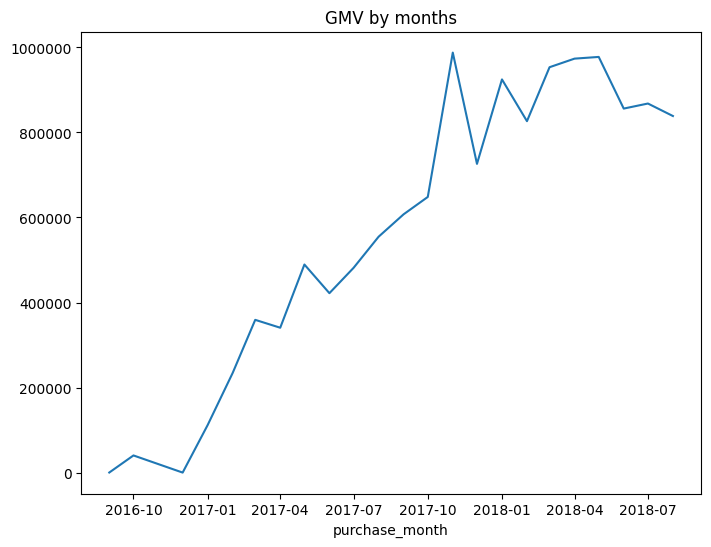

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(data = gmv.to_frame(), x = gmv.index.to_timestamp(), y = gmv.values)
plt.title("GMV by months")
plt.ticklabel_format(style='plain', axis='y')

## Metric 2: MAU — Active Monthly Users

MAU (Monthly Active Users) represents the number of unique customers who made at least one purchase in a given month.
This metric shows the size of the audience that actively uses the product and receives value from it.

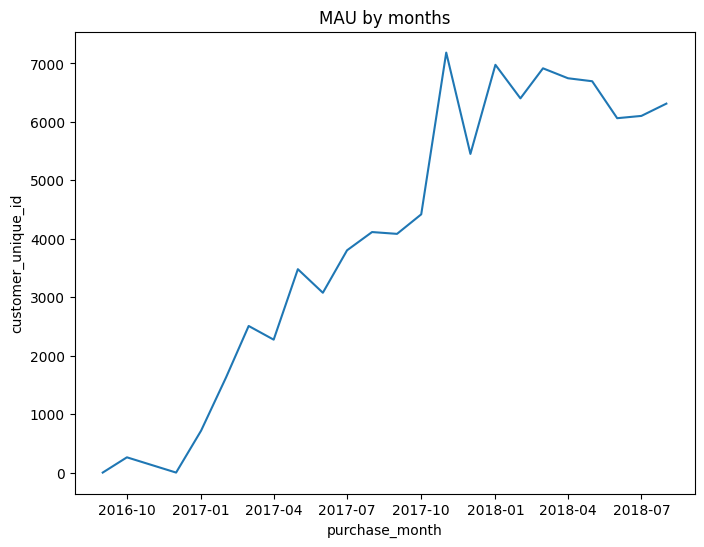

In [53]:
mau = orders_delivered.groupby("purchase_month")["customer_unique_id"].nunique().reset_index()
mau["purchase_month"] = mau["purchase_month"].dt.to_timestamp()

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(data = mau, x = mau["purchase_month"], y = "customer_unique_id")
plt.title("MAU by months")
plt.ticklabel_format(style='plain', axis='y')

## Metric 3: Conversion to Paying Customer

The conversion rate to paying customer (number of first-time buyers / number of registered users) shows how interested new users are in the product and how effectively the marketplace converts visitors into paying customers.

Since registration data is not available, this metric can’t be calculated directly in the current dataset.

## Metric 4: Repeat Customer Rate — Ongoing Customer Engagement

This metric measures the percentage of customers who made more than one purchase within a three-month period.
It reflects customer engagement and loyalty — whether users continue to buy after their first order.

Using a three-month window gives customers enough time to make another purchase, making the metric more meaningful for products with longer purchase cycles.

In [54]:
orders_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,purchase_month,purchase_day,cohort,cohort_day,period_number_month,price_total,freight_value_total,items_count
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,2017-10-02,2017-09,2017-09-04,0.0,29.99,8.72,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07,2018-07-24,2018-07,2018-07-24,0.0,118.70,22.76,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08,2018-08-08,2018-08,2018-08-08,0.0,159.90,19.22,1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11,2017-11-18,2017-11,2017-11-18,0.0,45.00,27.20,1
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02,2018-02-13,2018-02,2018-02-13,0.0,19.90,8.72,1


In [55]:
# get orders within 3 months window
win_3m = orders_delivered[orders_delivered["period_number_month"] <=3]
win_3m = (win_3m.groupby(['cohort', 'customer_unique_id'])['order_id']
    .nunique()
    .reset_index(name='orders_in_3m'))

#leave only repeat customers, group it by cohorts
repeat_customers_3m = win_3m[win_3m['orders_in_3m'] >= 2]
repeat_counts = (
    repeat_customers_3m
    .groupby('cohort')['customer_unique_id']
    .nunique()
    .rename('repeat_customers_3m'))

#calculate repeat_rate based on cohort size
repeat_rate_3m = (
    (repeat_counts / cohort_size)
    .fillna(0)
    .rename('repeat_rate_3m')
    .to_frame()
    .join(cohort_size, how='left')
    .join(repeat_counts, how='left')
    .fillna({'repeat_customers_3m': 0})
    .reset_index())
#trim first three months (have only customer in the cohort)
#and last three months (not enough time for 3-months window)
repeat_rate_3m = repeat_rate_3m.iloc[3:-3,:]
repeat_rate_3m["repeat_rate_3m"] = repeat_rate_3m["repeat_rate_3m"] * 100


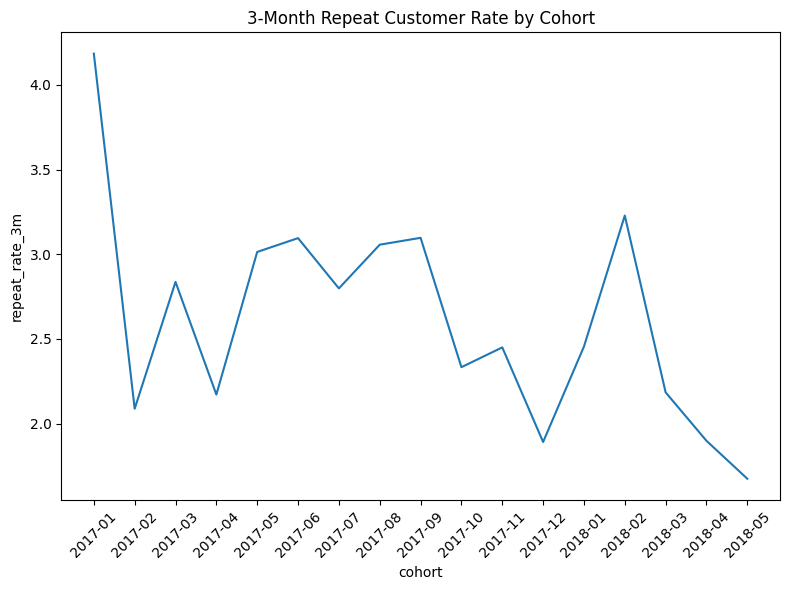

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    data=repeat_rate_3m,
    x=repeat_rate_3m["cohort"].astype(str),
    y="repeat_rate_3m",
    ax=ax
)

ax.set_title("3-Month Repeat Customer Rate by Cohort")
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [57]:
print(f"Median on 3-month Purchase Rate: {repeat_rate_3m["repeat_rate_3m"].median()}")

Median on 3-month Purchase Rate: 2.4554223911137094


## Metric 5: ARPPU — Monetary Expression of Customer Engagement

ARPPU (Average Revenue Per Paying User) shows the average revenue generated from each paying customer over a given period.

In [58]:
gmv = gmv.reset_index()
gmv["purchase_month"] = gmv["purchase_month"].dt.to_timestamp()
gmv_mau = gmv.merge(mau, on = "purchase_month")
gmv_mau["arppu"] = gmv_mau["price_total"] / gmv_mau["customer_unique_id"]

In [ ]:
gmv_mau

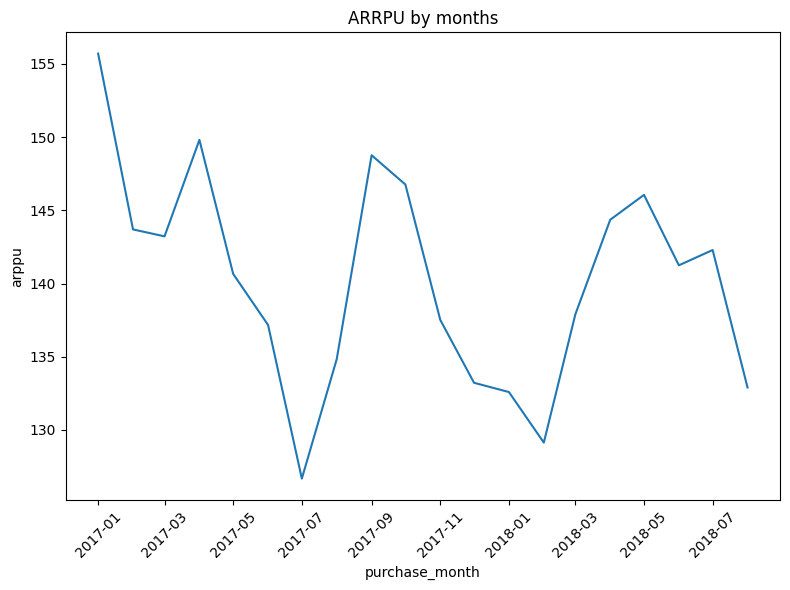

In [59]:
# drop first three months


fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    data=gmv_mau.iloc[3:,:],
    x="purchase_month",
    y="arppu",
    ax=ax
)

ax.set_title("ARRPU by months")
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can see that:
* GMV and MAU increased steadily until late 2017 but have since leveled off, signaling a slowdown in growth.

* The 3-month repeat rate remains low (around 2–3%), showing that most customers don’t return after their first purchase.

* ARPPU fluctuates with no clear upward trend, meaning revenue growth relies mainly on new customers.

**Overall, the marketplace has reached a plateau and further growth will depend on improving retention and customer experience.**

# 5. Hypothesis Prioritization (ICE Framework)

Based on the retention analysis, the team formulated three key hypotheses aimed at improving customer engagement and repeat purchases.
Each hypothesis was already scored for Ease and Confidence by the product team.

In this step, we’ll estimate the Impact (how strongly each change could influence the key metrics) using the ICE framework to prioritize initiatives.

For the calculation, we’ll use data starting from June 2017.

The conversion to repeat purchase will be set equal to 0.35% (the median first-month retention), as identified earlier in the cohort analysis.
After assigning the Impact scores, we’ll select the hypothesis with the highest overall ICE score for testing.

In [61]:
# impact score scale

def impact_score(segment_size):
    if segment_size < 50:
        return 1
    elif segment_size < 150:
        return 2
    elif segment_size < 350:
        return 3
    elif segment_size < 750:
        return 4
    elif segment_size < 1550:
        return 5
    elif segment_size < 3150:
        return 6
    elif segment_size < 6350:
        return 7
    elif segment_size < 12750:
        return 8
    elif segment_size < 25550:
        return 9
    elif segment_size < 51150:
        return 10


In [60]:
#filter data since June 2017
orders_062017 = orders[orders["order_purchase_timestamp"] >= "2017-06"].copy()
orders_062017.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [62]:
orders_062017 = orders_062017.merge(customers, on = "customer_id")


## Hypothesis 1
> If we fix the bug in the order system, customers won’t face order cancellations, and the number of delivered orders should grow.
<br><br>Confidence = 8
<br>Ease = 6

We’ll estimate the maximum possible impact, assuming all cancellations come from this bug.
In reality, some are caused by user actions or payment issues, so the real effect will be smaller.

To measure the impact, we’ll count how many customers had at least one canceled order.



We’ll assume that orders with the statuses “canceled” and “unavailable” (canceled due to out-of-stock items) represent all canceled orders in the system.

Let's check nulls

In [65]:
#calculate the impact: unique users with cancelled or unavaiable orders

total_customers = orders_062017.customer_unique_id.nunique()

h1_impact = (orders_062017[
           (orders_062017["order_status"] == "canceled") |
           (orders_062017["order_status"] == "unavaiable")]
            ["customer_unique_id"].nunique())

h1_impact_score = impact_score(h1_impact)
h1_confidence = 8
h1_ease = 6
print(f"Customers with cancelled or unavaiable orders: {h1_impact}")
print(f"% of total number of customers:{round(h1_impact*100/total_customers,2)}%")
print(f"Impact score: {h1_impact_score}")
print(f"ICE score:{h1_impact_score * h1_confidence * h1_ease}")

Customers with cancelled or unavaiable orders: 490
% of total number of customers:0.58%
Impact score: 4
ICE score:192


## Hypothesis 2

>If we reduce the time to ship an order, customers will stop receiving their purchases with delays, which should increase the total number of orders through more repeat purchases.
<br><br> Confidence = 10
<br> Ease = 4

To estimate the Impact, we’ll count how many customers experienced delays and then estimate how many of them could become repeat buyers if shipping times improved.

In [66]:
orders_062017["delayed"] = orders_062017["order_estimated_delivery_date"] < orders_062017["order_delivered_customer_date"]
orders_062017.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delayed
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,False
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,False
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,False
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,False
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,False


In [67]:
cr = 0.0035
delayed_customers = orders_062017[orders_062017["delayed"]]["customer_unique_id"].nunique()
h2_impact = delayed_customers * cr
h2_impact_score = impact_score(h2_impact)
h2_confidence = 10
h2_ease = 4
print(f"Number of customers with delayed order: {delayed_customers}")
print(f"Estimation of how many will repurchase {h2_impact}")
print(f"% of total number of customers:{round(h2_impact*100/total_customers,2)}%")
print(f"Impact score: {h2_impact_score}")
print(f"ICE score: {h2_impact_score * h2_confidence * h2_ease}")

Number of customers with delayed order: 7246
Estimation of how many will repurchase 25.361
% of total number of customers:0.03%
Impact score: 1
ICE score: 40


## Hypothesis 3

>If we introduce a new payment method that helps customers complete repeat purchases more easily, the total number of orders will grow through returning users who previously ordered only once.
<br><br> Confidence = 5
<br> Ease = 9

We’ll count how many customers made only one purchase and estimate how many of them could convert into repeat buyers.

In [ ]:
orders_062017.head()

In [69]:
cr = 0.0035
single_order_customers = (orders_062017.groupby("customer_unique_id")["order_id"].nunique()==1).sum()
h3_impact = single_order_customers * cr
h3_impact_score = impact_score(h3_impact)
h3_confidence = 5
h3_ease = 9
print(f"Number of customers with a single order: {single_order_customers}")
print(f"Estimation of how many will convert {h3_impact}")
print(f"% of total number of customers:{round(h3_impact*100/total_customers,2)}%")
print(f"Impact score: {h3_impact_score}")
print(f"ICE score: {h3_impact_score * h3_confidence * h3_ease}")

Number of customers with a single order: 82559
Estimation of how many will convert 288.9565
% of total number of customers:0.34%
Impact score: 3
ICE score: 135


**Among the three hypotheses, Hypothesis 1 has the highest ICE score of 192 point**
> If we fix the bug in the order system, customers won’t face order cancellations, and the number of delivered orders should grow.

## 6. Metrics for the Selected Hypothesis

We’ll test the chosen hypothesis using an A/B test.

**Next steps**:

* Define the main metrics the hypothesis should affect.

* Define target, proxy, and guardrail metrcis.

### Target Metric

We’ll use the Delivery Rate (delivered orders / total orders) as the target metric.

**Why:** this metric reflects the main goal of the hypothesis - increasing the number of completed deliveries.
Using a share instead of an absolute number removes distortions caused by fluctuations in the number of new customers.

In [70]:
# calculate the metric
total_orders = orders_062017.order_id.nunique()
delivered_orders = orders_062017[orders_062017["order_status"] == "delivered"]["order_id"].nunique()/total_orders
print(f"Delivery Rate {round(delivered_orders*100,4)}%")

Delivery Rate 97.3412%


### Proxy Metric

We’ll use the Pick-Up Rate (picked-up orders / total orders) as the proxy metric.

**Why:** the bug likely appears before orders are sent to the warehouse. During the EDA, we noticed inconsistencies in carrier handover dates. If the issue is fixed, the share of orders reaching the carrier should increase.
This metric is more sensitive and can show improvements earlier than the target metric.

If the problem isn’t related to logistics, we can instead use the Cancellation Rate as the proxy metric.

In [71]:
picked_up_orders = orders_062017[~orders_062017["order_delivered_carrier_date"].isna()].order_id.nunique()/total_orders
print(f"Pick Up Rate {round(picked_up_orders*100,4)}%")

Pick Up Rate 98.4592%


In [72]:
canceled_orders = orders_062017[(orders_062017["order_status"] == "canceled") |
            (orders_062017["order_status"] == "unavaiable")].order_id.nunique()/total_orders
print(f"Cancellation Rate {round(canceled_orders*100,4)}%")

Cancellation Rate 0.5687%


### Guardrail Metric

We'll use Order Conversion Rate as a guardrail metric&

It’s calculated as the share of active users who placed an order.

**Why:** to make sure that fixing the bug doesn’t harm the overall customer experience or reduce the likelihood of placing another order.

# Summary and Next Steps


1. The product shows very **low retention** (the median first-month retention rate is 0.35%).

2. The marketplace **has not reached product–market fit**. This is supported by the low retention and weak repeat activity: only 3% of customers made more than one purchase, and the share of repeat buyers keeps declining over time.

3. Possible reasons for the lack of product–market fit include order processing issues (inconsistent timestamps found in the data) and delivery delays — about 8.5% of customers received their orders late.

To improve performance, it’s recommended to run an A/B test to validate the hypothesis:
*"If we fix the bug in the order processing system, customers will no longer face order cancellations, leading to an increase in delivered orders."*